<a href="https://colab.research.google.com/github/hassonlab/247-plotting/blob/main/tfspaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is aimed to replicate the experiement results on comparison of contexual embeddings and brain embeddings for the paper "Brain embeddings and artificial contextual embeddings converge on a shared geometry for natural language"

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage
client = storage.Client(project='eeg-247')
bucket = client.get_bucket('247-podcast-data')

In [ ]:
import io
import pickle
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
import scipy.spatial as spatial
from scipy import signal as sig_scipy
from scipy.stats import zscore
from statsmodels.stats import multitest
from statsmodels.stats import stattools
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
for blob in client.list_blobs('247-podcast-data',prefix='podcast-pickles/777/'):
  print(blob.name)

podcast-pickles/777/777_bin_stitch_index.pkl
podcast-pickles/777/777_binned_signal.pkl
podcast-pickles/777/777_electrode_names.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_01_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_02_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_03_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_04_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_05_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_06_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_07_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_08_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_09_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_10_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_11_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_12_embeddings.pkl
podcast-pickles/777/777_full_bert_cnxt_512_layer_13_embeddings.pk

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Loading electrode name-id mapping pkl file and contextual word embeddings pkl file from google cloud storage
# glove Embedding path: podcast-pickles/777/777_full_glove50_layer_01_embeddings.pkl
ds = pickle.loads(storage.Blob('podcast-pickles/777/777_electrode_names.pkl', bucket).download_as_string())
elec_df = pd.DataFrame(ds)

ds = pickle.loads(storage.Blob('podcast-pickles/777/777_full_gpt2-xl_cnxt_1024_layer_48_embeddings.pkl', bucket).download_as_string())
ds2 = pd.read_pickle('/content/drive/MyDrive/RESEARCH/HassonLab/777_full_gpt2-xl_cnxt_1023_layer_48_embeddings.pkl')
ds = pickle.loads(storage.Blob('podcast-pickles/777/777_full_glove50_layer_01_embeddings.pkl', bucket).download_as_string())
emb_gpt2 = pd.DataFrame(ds)
emb_gpt2_2 = pd.DataFrame(ds2)
# df = pd.DataFrame(ds)

In [ ]:
emb_gpt2_2.columns

Index(['word', 'word_without_punctuation', 'index', 'datum_word', 'onset',
       'offset', 'accuracy', 'speaker', 'is_nonword', 'cloze',
       'sentence_signal_length', 'sentence', 'num_words', 'sentence_idx',
       'adjusted_onset', 'adjusted_offset', 'conversation_id',
       'conversation_name', 'production', 'word_freq_overall',
       'word_freq_phase', 'lemmatized_word', 'stemmed_word', 'in_glove',
       'in_gpt2', 'in_bert_base_cased', 'in_blenderbot_small_90M',
       'in_blenderbot_3B', 'token', 'token2word', 'token_id',
       'gpt2-xl_token_is_root', 'token_idx', 'fold', 'top1_pred',
       'top1_pred_prob', 'true_pred_prob', 'surprise', 'entropy',
       'embeddings'],
      dtype='object')

In [ ]:
emb_gpt2.columns

Index(['word', 'word_without_punctuation', 'index', 'datum_word', 'onset',
       'offset', 'accuracy', 'speaker', 'is_nonword', 'cloze',
       'sentence_signal_length', 'sentence', 'num_words', 'sentence_idx',
       'adjusted_onset', 'adjusted_offset', 'conversation_id',
       'conversation_name', 'production', 'word_freq_overall',
       'word_freq_phase', 'lemmatized_word', 'stemmed_word', 'in_glove',
       'in_gpt2', 'in_bert_base_cased', 'in_blenderbot_small_90M',
       'in_blenderbot_3B', 'embeddings'],
      dtype='object')

In [ ]:
emb_gpt2

,word,word_without_punctuation,index,datum_word,onset,offset,accuracy,speaker,is_nonword,cloze,...,word_freq_overall,word_freq_phase,lemmatized_word,stemmed_word,in_glove,in_gpt2,in_bert_base_cased,in_blenderbot_small_90M,in_blenderbot_3B,embeddings
0,act,Act,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,3,3,Act,act,True,True,True,True,True,"[-0.60647, -0.65705, -1.1819, -0.61002, -0.197..."
1,one,One,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,2,2,"One,","one,",False,False,False,False,False,None
2,monkey,Monkey,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,36,36,Monkey,monkey,True,True,True,True,False,"[0.28704, -0.60904, -0.74821, 0.17686, 0.92118..."
3,in,in,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,100,100,in,in,True,True,True,True,True,"[0.33042, 0.24995, -0.60874, 0.10923, 0.036372..."
4,the,the,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,299,299,the,the,True,True,True,True,True,"[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,go,go,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,5,5,go,go,True,True,True,True,True,"[0.14828, 0.17761, 0.42346, -0.31489, 0.32273,..."
5113,to,to,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,152,152,to,to,True,True,True,True,True,"[0.68047, -0.039263, 0.30186, -0.17792, 0.4296..."
5114,court,court,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,12,12,court,court,True,True,True,True,True,"[-0.35445, -0.55181, -1.024, 0.59384, 0.57911,..."
5115,over,over,NaN,None,NaN,NaN,NaN,Speaker2,None,NaN,...,7,7,over,over,True,True,True,True,True,"[0.12972, 0.088073, 0.24375, 0.078102, -0.1278..."


In [ ]:
print(emb_gpt2.columns)

Index(['word', 'word_without_punctuation', 'index', 'datum_word', 'onset',
       'offset', 'accuracy', 'speaker', 'is_nonword', 'cloze',
       'sentence_signal_length', 'sentence', 'num_words', 'sentence_idx',
       'adjusted_onset', 'adjusted_offset', 'conversation_id',
       'conversation_name', 'production', 'word_freq_overall',
       'word_freq_phase', 'lemmatized_word', 'stemmed_word', 'in_glove',
       'in_gpt2', 'in_bert_base_cased', 'in_blenderbot_small_90M',
       'in_blenderbot_3B', 'embeddings'],
      dtype='object')


In [ ]:
print(emb_gpt2_2.columns)

Index(['word', 'word_without_punctuation', 'index', 'datum_word', 'onset',
       'offset', 'accuracy', 'speaker', 'is_nonword', 'cloze',
       'sentence_signal_length', 'sentence', 'num_words', 'sentence_idx',
       'adjusted_onset', 'adjusted_offset', 'conversation_id',
       'conversation_name', 'production', 'word_freq_overall',
       'word_freq_phase', 'lemmatized_word', 'stemmed_word', 'in_glove',
       'in_gpt2', 'in_bert_base_cased', 'in_blenderbot_small_90M',
       'in_blenderbot_3B', 'token', 'token2word', 'token_id',
       'gpt2-xl_token_is_root', 'token_idx', 'fold', 'top1_pred',
       'top1_pred_prob', 'true_pred_prob', 'surprise', 'entropy',
       'embeddings'],
      dtype='object')


In [ ]:
# emb_gpt2_2[['fold']]

,fold
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
6148,9.0
6149,9.0
6150,9.0
6151,9.0


In [ ]:
# df['word'] = df.word.str.lower().str.strip(string.punctuation)
# nans = df['embeddings'].isna()
# # nans = df.embeddings.apply(lambda x: np.isnan(x).any())
# # same = df.token2word.str.lower().str.strip() == df.word.str.lower().str.strip()
# notnon = df.is_nonword == 0
# df2 = df[~nans & notnon].copy()
# df2.reset_index(drop=True, inplace=True)
# assert not df2.adjusted_onset.isna().any()
# df3 = df2[['word', 'adjusted_onset']].copy()
# dfz = df3.groupby('word').apply(lambda x: x.sample(1, random_state=42))
# dfz.reset_index(level=1, inplace=True)
# dfz.sort_values('adjusted_onset', inplace=True)
# df = df2.iloc[dfz.level_1.values]

In [ ]:
# Experiment List
experiment_list = [
    ('717_NYU_class_IFG', [[717, 'LGA11', 'LGA12', 'LGA19', 'LGA20', 'LGA27', 'LGA28', 'LGB73', 'LGB76', 'LGB81', 'LGB82', 'LGB83', 'LGB84', 'LGB88',
                          'LGB89', 'LGB96', 'LGB97', 'LGB98', 'LGB99', 'LGB108', 'LGB109', 'LGA25', 'LGA26', 'LGA34', 'LGB106', 'LGB107', 'LGA9',
                          'LGA10', 'LGA17', 'LGA18', 'LGB74', 'LGB75', 'LGB77', 'LGB78', 'LGB79', 'LGB80', 'LGB86', 'LGB87', 'LGB92', 'LGB93', 'LGB94', 'LGB95']]),
    ('742_NYU_class_IFG', [[742, 'G34','G35','G45','G116','G117','G61','G43','G44','G51','G52','G53','G60','G124','G128']]),
    ('798_NYU_class_IFG', [[798, 'G19','G20','G27','G81','G83','G84','G88','G95','G96','G97','G98','G107','G108','G17','G18','G25','G26','G33',
                            'G77','G79','G86','G87','G92','G93','G94','G106']]),
    ('all3_NYU_class_IFG', [
      [717, 'LGA11', 'LGA12', 'LGA19', 'LGA20', 'LGA27', 'LGA28', 'LGB73', 'LGB76', 'LGB81', 'LGB82', 'LGB83', 'LGB84', 'LGB88',
            'LGB89', 'LGB96', 'LGB97', 'LGB98', 'LGB99', 'LGB108', 'LGB109', 'LGA25', 'LGA26', 'LGA34', 'LGB106', 'LGB107', 'LGA9',
            'LGA10', 'LGA17', 'LGA18', 'LGB74', 'LGB75', 'LGB77', 'LGB78', 'LGB79', 'LGB80', 'LGB86', 'LGB87', 'LGB92', 'LGB93', 'LGB94', 'LGB95'],
      [742, 'G34', 'G35', 'G45', 'G116', 'G117', 'G61', 'G43', 'G44', 'G51', 'G52', 'G53', 'G60', 'G124', 'G128'],
      [798, 'G19', 'G20', 'G27', 'G81', 'G83', 'G84', 'G88', 'G95', 'G96', 'G97', 'G98', 'G107', 'G108', 'G17', 'G18', 'G25', 'G26', 'G33',
            'G77', 'G79', 'G86', 'G87', 'G92', 'G93', 'G94', 'G106']]),
    ('all3_NYU_class_precentral', [
      [717,'LGA5', 'LGA6','LGA7','LGA13','LGA21','LGA29','LGB85','LGB100'],
      [742,'G1','G9','G19','G27','G28','G36','G37','G68','G74','G78','G79','G87','G88','G95','G97','G98','G107','G108','G109','G112'],
      [798,'G7','G8','G14','G15','G16','G21','G22','G28','G29','G35','G36','G85','G89','G90','G99','G100','G101','G109']])]

In [ ]:
def load_mat_file(pid, eid, bucket=None):

  """load specific patient electrode signal mat file based on patient id and electrode id.

  Args:
    pid:                patient id number
    eid:                electrode id number
    bucket(optional):   google cloud bucket name if given
  Returns:
    elec_signal:        a numpy array of electrode signals for the specific patient and electrode id, shape as (num_signals , 1)

  """
  elec_signal=[]
  if bucket:
    load_path = 'podcast_data/'+str(pid)+'/NY'+str(pid)+'_111_Part1_conversation1/preprocessed_all/NY'+str(pid)+'_111_Part1_conversation1_electrode_preprocess_file_'+str(eid)+'.mat'
    blob = storage.Blob(load_path, bucket)
    matfile = loadmat(io.BytesIO(blob.download_as_string()))
    elec_signal = matfile['p1st']
  else:
    pass
  return elec_signal

In [ ]:
def get_signals_for_experiment(experiment_name):

  """get patient electrode signals for one specific experiment based on experiment name, using function load_mat_file to load signals

  Args:
    experiment_name:  a string of a experiment name, e.g. '717_NYU_class_IFG'
  Returns:
    a numpy array of all electrode signals from patients for one specific experiment, shape as (num_electrodes_across_patient, num_signals)

  """
  pe_dict = {}
  for exp_name, electrodes_desc in experiment_list:
    if exp_name == experiment_name:
      for el_list in electrodes_desc:
        p_id = el_list[0]
        pe_dict[p_id] = []
        for e_name in el_list[1:]:
          e_id = elec_df[(elec_df['subject']==p_id)&(elec_df['electrode_name']==e_name)]['electrode_id'].values[0]
          pe_dict[p_id].append(e_id)

  ret_signals = []
  for patient , el in pe_dict.items():
    for electrode in el:
      elec_signal = load_mat_file(patient, electrode, bucket)
      ret_signals.append(elec_signal.reshape(-1, 1))
  return np.stack(ret_signals).squeeze()

In [ ]:
def get_exp_signals(exp_list):

  """get all patient electrode signals for a list of experiments based on an experiment list

  Args:
    exp_list:       a list of strings as experiment names
  Returns:
    ret_exp_sigs:   a dictionary of all experments electrode signals with experiment name as the key, signals as the paired value

  """
  ret_exp_sigs = {}
  for experiment in exp_list:
    # print(experiment[0])
    experiment_name = experiment[0]
    ret_exp_sigs[experiment_name] = get_signals_for_experiment(experiment_name)
  return ret_exp_sigs

In [ ]:
def get_data_glove(df, kfolds=10):

  """get preprocessed embedding data from embedding files; create non-overlap 10-fold index list for train/valid/test dataset

  Args:
    df:                   a panda dataframe of gpt2 contextual word embedding
    kfolds:               an integer that indicates the number of kfold for cross-validation computation
  Returns:
    embeddings:           a numpy array of preprocessed embeddings, shape as (num_word, embedding_dimension)
    shuffled_embeddings:  a numpy array of shuffled preprocessed embeddings, shape as (num_word, embedding_dimension) as baseline
    onsets:               a numpy array of word onsets time, shape as (num_word, )
    ret_folds_idxs:       a list of index of train/valid/test dataset within each cross-validation

  """
  df['word'] = df.word.str.lower().str.strip(string.punctuation)
  # nans = df['embeddings'].isna()
  nans = df.embeddings.apply(lambda x: np.isnan(x).any())
  same = df.token2word.str.lower().str.strip() == df.word.str.lower().str.strip()
  notnon = df.is_nonword == 0
  df2 = df[~nans & notnon].copy()
  df2.reset_index(drop=True, inplace=True)
  assert not df2.adjusted_onset.isna().any()
  df3 = df2[['word', 'adjusted_onset']].copy()
  dfz = df3.groupby('word').apply(lambda x: x.sample(1, random_state=42))
  dfz.reset_index(level=1, inplace=True)
  dfz.sort_values('adjusted_onset', inplace=True)
  df = df2.iloc[dfz.level_1.values]

  onsets = df.adjusted_onset.values.astype(int)
  embeddings = np.stack(df.embeddings.values)

  indices = np.arange(len(embeddings))
  np.random.shuffle(indices)
  shuffled_embeddings = embeddings[indices]
  ret_folds_idxs = []
  skf = KFold(n_splits=kfolds, shuffle=False)
  n_samps = len(embeddings)
  folds = [t[1] for t in skf.split(np.arange(n_samps))]
  for i in range(kfolds):
    folds_ixs = np.roll(range(kfolds), i)
    test_fold = folds_ixs[-1]
    train_folds = folds_ixs[:-1]
    test_index = folds[test_fold]
    train_index = np.concatenate([folds[j] for j in train_folds])
    test_embeddings = embeddings[test_index]
    train_embeddings = embeddings[train_index]
    knn=NearestNeighbors(n_neighbors=1, metric='cosine')
    knn.fit(train_embeddings)
    _, I = knn.kneighbors(test_embeddings)
    test_nn_index = train_index[I.squeeze()]
    ret_folds_idxs.append((test_index, test_nn_index, train_index))

  return (embeddings, shuffled_embeddings, onsets, ret_folds_idxs)

In [ ]:
def get_data(df, kfolds=10):

  """get preprocessed embedding data from embedding files; create non-overlap 10-fold index list for train/valid/test dataset

  Args:
    df:                   a panda dataframe of gpt2 contextual word embedding
    kfolds:               an integer that indicates the number of kfold for cross-validation computation
  Returns:
    embeddings:           a numpy array of preprocessed embeddings, shape as (num_word, embedding_dimension)
    shuffled_embeddings:  a numpy array of shuffled preprocessed embeddings, shape as (num_word, embedding_dimension) as baseline
    onsets:               a numpy array of word onsets time, shape as (num_word, )
    ret_folds_idxs:       a list of index of train/valid/test dataset within each cross-validation

  """
  df['word'] = df.word.str.lower().str.strip(string.punctuation)
  # nans = df['embeddings'].isna()
  nans = df.embeddings.apply(lambda x: np.isnan(x).any())
  same = df.token2word.str.lower().str.strip() == df.word.str.lower().str.strip()
  notnon = df.is_nonword == 0
  df2 = df[same & ~nans & notnon].copy()
  df2.reset_index(drop=True, inplace=True)
  assert not df2.adjusted_onset.isna().any()
  df3 = df2[['word', 'adjusted_onset']].copy()
  dfz = df3.groupby('word').apply(lambda x: x.sample(1, random_state=42))
  dfz.reset_index(level=1, inplace=True)
  dfz.sort_values('adjusted_onset', inplace=True)
  df = df2.iloc[dfz.level_1.values]

  onsets = df.adjusted_onset.values.astype(int)
  embeddings = np.stack(df.embeddings.values)
  indices = np.arange(len(embeddings))
  np.random.shuffle(indices)
  shuffled_embeddings = embeddings[indices]
  ret_folds_idxs = []
  skf = KFold(n_splits=kfolds, shuffle=False)
  n_samps = len(embeddings)
  folds_old = [t[1] for t in skf.split(np.arange(n_samps))]
  print("Provided Fold")
  folds = []
  given_fold = df['fold'].tolist()
  for _ in set(given_fold):
      folds.append(np.array([], dtype=int))
  for index, fold in enumerate(given_fold):
      folds[int(fold)] = np.append(folds[int(fold)], index)

  print(len(folds_old))
  print(len(folds))
  print()
  for i in range(kfolds):
    folds_ixs = np.roll(range(kfolds), i)
    test_fold = folds_ixs[-1]
    train_folds = folds_ixs[:-1]
    test_index = folds[test_fold]
    train_index = np.concatenate([folds[j] for j in train_folds])
    test_embeddings = embeddings[test_index]
    train_embeddings = embeddings[train_index]
    knn=NearestNeighbors(n_neighbors=1, metric='cosine')
    knn.fit(train_embeddings)
    _, I = knn.kneighbors(test_embeddings)
    test_nn_index = train_index[I.squeeze()]
    ret_folds_idxs.append((test_index, test_nn_index, train_index))

  return (embeddings, shuffled_embeddings, onsets, ret_folds_idxs)


In [ ]:
def create_target(signals, onsets, poly_degree = 2, window_size = 200, lag_range = 4000, increment = 25):

  """create the target signals with 200 ms window size, at 161 lags at 25-ms increments from -4000 ms to 4000 ms

  Args:
    signals:        a numpy array of all electrode signals from patients for one specific experiment, shape as (num_electrodes_across_patient, num_signals)
    onsets:         a numpy array of adjusted onsets time for each word from the contextual embeddings table, shape as (num_word, )
    poly_degree:    an integer indicates the polynomial degree for the detrending process
    window_size:    an integer indicates the window size of the target signals, unit in millisecond
    lag_range:      an integer indicates the lag range for the experiement, unit in millisecond
    increment:      an integer indicates the increment pace for the moving between lags, unit in millisecond

  Returns:
    y: a numpy array of target singals for epxerments with specified window size, lag range, shape as (num_word, num_lags, num_electrodes)

  """
  # Using PolynomialFeatures as preprocessing for detrending signals
  y = signals.T
  X = np.arange(len(y)).reshape(-1, 1)
  pf = PolynomialFeatures(degree=poly_degree)
  Xp = pf.fit_transform(X)
  model = LinearRegression()
  model.fit(Xp, y)
  trend = model.predict(Xp)
  y -= trend
  signals = y.T

  n_electrodes, n_samples = signals.shape
  half_window = round((window_size / 1000) * 512 / 2)
  lags = range(-lag_range, lag_range, increment)
  lags = np.array(lags)
  y = np.zeros((len(onsets), len(lags), n_electrodes))
  for lag in range(len(lags)):
    lag_amount = int(lags[lag] / 1000 * 512)
    index_onsets = np.minimum(
        n_samples - half_window - 1,
        np.maximum(half_window + 1,
                   onsets + lag_amount))
    starts = index_onsets - half_window - 1
    stops = index_onsets + half_window
    sls_signals = signals[:, np.concatenate([np.arange(s,t) for s,t in zip(starts, stops)])]
    sls_signals = sls_signals.reshape([n_electrodes, len(onsets), -1])
    y[:, lag, :] = np.transpose(np.mean(sls_signals, axis=-1))

  return y

In [ ]:
def cross_validate(x, y, folds_idxs, pca=50):

  """train predictors using kfold cross validation.

  Args:
    x:            a numpy array of preprocessed embeddings, shape as (num_word, embedding_dimension)
    y:            a numpy array of target brain singals for specific experiment with specified window size, lag range, shape as (num_word, num_lags, num_electrodes)
    folds_idxs:   an integer that indicates the number of kfold for cross-validation computation
    pca:          an integer that indicates the PCA dimension
  Returns:
    y_hat:        a numpy array of predicted brain embeddings for specific experiment, shape as (num_word, num_lags, num_electrodes)
    y_hat_nn:     a numpy array of nearest neighbor word predicted brain embeddings for specific experiment, shape as (num_word, num_lags, num_electrodes)

  """
  n_samps = x.shape[0]
  n_chans = y.shape[1] if y.shape[1:] else 1
  n_electrodes = y.shape[2] if y.shape[2:] else 1
  y_hat = np.zeros((n_samps, n_chans, n_electrodes))
  y_hat_nn = np.zeros((n_samps, n_chans, n_electrodes))

  for test_index, test_nn_index, train_index in folds_idxs:
    x_tra, x_tes, x_tes_nn = x[train_index], x[test_index], x[test_nn_index]
    y_tra, y_tes, _ = y[train_index], y[test_index], y[test_nn_index]

    # using PCA as dimension reduction and scaling processing
    model = make_pipeline(PCA(pca, whiten=True), LinearRegression())
    model.fit(x_tra, y_tra.reshape(y_tra.shape[0], -1))
    fold_yhat = model.predict(x_tes)
    fold_yhat_nn = model.predict(x_tes_nn)

    fold_yhat = fold_yhat.reshape(fold_yhat.shape[0], y_tra.shape[1], -1 )
    fold_yhat_nn = fold_yhat_nn.reshape(fold_yhat_nn.shape[0], y_tra.shape[1], -1 )
    y_hat[test_index, :, :] = fold_yhat
    y_hat_nn[test_index, :, :] = fold_yhat_nn

  return y_hat, y_hat_nn

In [ ]:
def compute_correlations(yh, y):
  """compute correlation between expected and predicted values.

  Args:
    yh:          a numpy array of predicted brain embeddings for specific experiment, shape as (num_word, num_lags, num_electrodes)
    y:           a numpy array of actual brain singals for specific experiment, shape as (num_word, num_lags, num_electrodes)
  Returns:
    lags_corr:   a list of word level correlation for each lags bewtween predicted brain embeddings and actual brain embeddings

  """
  y = zscore(y, axis=0)
  yh = zscore(yh, axis=0)
  lags_corr = []
  for lag in range(yh.shape[1]):
    ca, cb = yh[:, lag, :], y[:, lag, :]
    ca_mean = ca.mean(axis=1, keepdims=True)
    cb_mean = cb.mean(axis=1, keepdims=True)
    ca_stddev = np.sum((ca - ca_mean)**2, axis=1)
    cb_stddev = np.sum((cb - cb_mean)**2, axis=1)
    nom = np.sum((ca - ca_mean) * (cb - cb_mean), axis=1)
    den = np.sqrt(ca_stddev * cb_stddev)
    lags_corr.append(nom/den)
  return lags_corr

In [ ]:
def fdr(pvals):
  """p-value correction for multiple tests using Benjamini/Hochberg false discovery rate method"""
  _, pcor, _, _ = multitest.multipletests(pvals,method='fdr_bh',is_sorted=False)
  return pcor

def one_samp_perm(x, nperms):
  """permutate the differences in performance across words and assign the mean difference to a null difference,
     get the p-value from one sample permutation based on the null hypothesis that the correlation between predicted embedding and actual brain embedding is zero

  Args:
    x:        correlation value
    nperms:   number of time of permutation

  Returns:
    p_value:  p-value based on the null hypothesis that the correlation between predicted embedding and actual brain embedding is zero

  """
  n = len(x)
  dist = np.zeros(nperms)
  for i in range(nperms):
      dist[i] = np.random.choice(x, n, replace=True).mean()
  val = np.sum(dist > 0)
  p_value = 1 - val / nperms
  return p_value

def paired_permutation(x, y, nperms):
  """compute p-value for the difference between two embeddings (e.g.the test embedding and the nearest training embedding)
     based on a null distribution

  Args:
    x:          a list of conrrelation value from one embeddings
    y:          a list of conrrelation value from another one embeddings (e.g. nearest neighbor word embeddings)
    nperms:     number of time of permutation

  Returns:
    p_values:   p-value for the difference between two embeddings based on the null distribution

  """
  n = len(x)
  truescore = (x - y).mean()
  dist = np.zeros(nperms)
  for i in range(nperms):
      s = np.random.choice([1, -1], n)
      dist[i] = np.mean(s * (x-y))
  p_value = (truescore > dist).mean()
  return p_value

def correlation_significance(corrs, corrs2, nperms, lags):
  """main function to calculate correlation significance using permutation tests

  Args:
    corrs:      a list of conrrelation value from one embeddings across all lags
    corrs2:     a list of conrrelation value from another one embeddings across all lags
    nperms:     number of time of permutation
    lags:       number of lags

  Returns:
    minP:       an integer that indicates the minimum p-value that is based on the null hypothesis that the correlation between predicted embedding and
                actual brain embedding is zero
    siglags:    the lags points that have significant correlation between the test embedding
                and the nearest training embedding based on a null distribution

  """
  # calculate min correlation p-value for one sample permutation
  pvals = [one_samp_perm(corrs[i], nperms) for i in range(len(lags))]
  # print('print len(lags) here:')
  # print(len(lags))
  # print()
  # print('print pvals here: ')
  # print(len(pvals))
  # print(pvals)
  # print()

  pcorr = fdr(pvals)
  mean_corr = corrs.mean(axis=1)

  # print('print mean_corr here: ')
  # print(mean_corr.shape)
  # print(mean_corr)
  # print()

  minP = 0
  g = pcorr <= 0.01
  # print('print g here: ')
  # print(len(g))
  # print(g)
  # print()

  if g.any():
      # print('print g here: ')
      # print(len(g))
      # print(g)
      # print()
      sigSig = mean_corr[g]
      # print('print sigSig here:')
      # print(len(sigSig))
      # print(sigSig)
      # print()
      if (pcorr > 0.01).any():
          maxP = mean_corr[pcorr > 0.01].max()
          # print('print(mean_corr[pcorr > 0.01]')
          # print(len(mean_corr[pcorr > 0.01]))
          # print(mean_corr[pcorr > 0.01])
          # print()
          gg = sigSig > maxP
          if gg.any():
              minP = sigSig[gg].min()
              # print('print minP here:')
              # print(minP)
              # print()

  # pair permutation
  pair_pvals = [paired_permutation(corrs2[i], corrs[i], nperms) for i in range(len(lags))]
  # print('print pair_pvals here:')
  # print(len(pair_pvals))
  # print(pair_pvals)
  # print()
  pair_pcorr = fdr(pair_pvals)
  # print('print pair_pcorr here:')
  # print(len(pair_pcorr))
  # print(pair_pcorr)
  # print()
  issig = (mean_corr > minP) & (pair_pcorr < 0.01)
  # print('print issig here:')
  # print(len(issig))
  # print(issig)
  # print()
  siglags = issig.nonzero()[0]
  # print('print siglags here:')
  # print(len(siglags))
  # print(siglags)
  # print()

  return minP, siglags

In [ ]:
def plot_elec_sig(expname, correlations, num_electrodes, lag_range = 4000, increment = 25):

  """ plot zero-shot encoding between the contextual embeddings and the brain embeddings which including:

  Args:
    exname:           a string that indicates experiment name, e.g. '717_NYU_class_IFG'
    correlations:     a list of experiment correlation results, in the order of predicted braining embeddings, nearest neighbor predicted braining embeddings and shuffled predicted braining embeddings
    num_electrodes:   an integer that indicates the number of electrodes used in specific experiment
    lag_range:        an integer indicates the lag range for the experiement, unit in millisecond
    increment:        an integer indicates the increment pace for the moving between lags, unit in millisecond

  Display:
    plots that indicates the shared gerometry between contextual embeddings and brain embeddings
    1) solid blue line: average correlation in brain region of interest between the predicted brain embedding and the actual embedding for all words across all test sets
    2) solid read line: average correlation in brain region of interest between the predicted brain embedding and the embedding for word as nearest neighbor to each test word
    3) black line: significant difference (FDR corrected) between the correlation with the actual contextual embeddings (blue line) and
       the correlation with the nearest embedding from the training set (red line).
    4) blue asterisks: significant difference (FDR corrected) between the correlation with the actual contextual embeddings (blue line) and
       the correlation with the nearest embedding from the training set (red line).
    5) black line: the zero-shot encoding between shuffled contextual embeddings and brain embeddings

  """
  nperms = 5000
  colors = ['blue', 'red', 'gray']
  plt.rcParams.update({"text.usetex": False})

  lags = np.arange(-lag_range, lag_range, increment)
  fig, ax = plt.subplots()
  ax.set_ylim(-0.05, 0.17)
  yheight = ax.get_ylim()[1] - .005
  print('print yheight here')
  print(yheight)
  print()



  # plot correlation significance
  minP, siglags = correlation_significance(correlations[0], correlations[1], nperms, lags)
  ax.axhline(minP)
  ax.scatter(lags[siglags], [yheight]*len(siglags), marker='*', color='blue')

  print('print minP here')
  print(minP)
  print()

  print('print lags here')
  print(len(lags))
  print(lags)
  print()

  print('print lags[siglags] here')
  print(len(lags[siglags]))
  print(lags[siglags])
  print()

  # plot average correlation
  maxc = []
  for i, corr in enumerate(correlations):

    corrs = np.mean(corr, axis=1)
    err = corr.std(axis=1)/np.sqrt(corr.shape[1])
    ax.plot(lags, corrs, color=colors[i])
    ax.fill_between(lags, corrs - err, corrs + err, alpha=0.1, color=colors[i])
    maxc.append(max(corrs))

  unsh_mx = maxc[0]
  nn_mx = maxc[1]
  ax.set(xlabel='lag (s)', ylabel='correlation', title="%s unsh max %4.2f nn max %4.2f (%d electrodes)"%(expname, unsh_mx, nn_mx, num_electrodes))
  ax.vlines(0, -0.05, 0.50, linestyles='dashed', linewidth=.25)
  plt.show()
  plt.close()

In [ ]:
def run_experiments_sig(exp_list, names=None):
  """master function to run the whole experiments

  Args:
    exp_list:     a list of strings as experiment names
  Returns:
    plots:        a series of zero-shot encoding plots

  """
  # comp_x, comp_x_shuffled, onsets, folds_idxs = get_data(emb_gpt2)
  comp_x, comp_x_shuffled, onsets, folds_idxs = get_data(emb_gpt2_2)

  exp_sigs = get_exp_signals(exp_list)

  for experiment in exp_list:
    experiment_name = experiment[0]
    if not names or experiment_name in names:
      print(experiment_name)
      exp_sig = exp_sigs[experiment_name]
      num_electrodes = exp_sig.shape[0]
      y = create_target(exp_sig, onsets)
      yh, yh_nn = cross_validate(comp_x, y, folds_idxs)
      yh_sh, _ = cross_validate(comp_x_shuffled, y, folds_idxs)
      exp_results = compute_correlations(yh, y)
      exp_results_nn = compute_correlations(yh_nn, y)
      exp_results_sh = compute_correlations(yh_sh, y)
      plot_elec_sig(experiment_name, [np.array(exp_results), np.array(exp_results_nn), np.array(exp_results_sh)], num_electrodes)

Provided Fold
10
10

717_NYU_class_IFG
print yheight here
0.165

print minP here
0.018304774032308423

print lags here
320
[-4000 -3975 -3950 -3925 -3900 -3875 -3850 -3825 -3800 -3775 -3750 -3725
 -3700 -3675 -3650 -3625 -3600 -3575 -3550 -3525 -3500 -3475 -3450 -3425
 -3400 -3375 -3350 -3325 -3300 -3275 -3250 -3225 -3200 -3175 -3150 -3125
 -3100 -3075 -3050 -3025 -3000 -2975 -2950 -2925 -2900 -2875 -2850 -2825
 -2800 -2775 -2750 -2725 -2700 -2675 -2650 -2625 -2600 -2575 -2550 -2525
 -2500 -2475 -2450 -2425 -2400 -2375 -2350 -2325 -2300 -2275 -2250 -2225
 -2200 -2175 -2150 -2125 -2100 -2075 -2050 -2025 -2000 -1975 -1950 -1925
 -1900 -1875 -1850 -1825 -1800 -1775 -1750 -1725 -1700 -1675 -1650 -1625
 -1600 -1575 -1550 -1525 -1500 -1475 -1450 -1425 -1400 -1375 -1350 -1325
 -1300 -1275 -1250 -1225 -1200 -1175 -1150 -1125 -1100 -1075 -1050 -1025
 -1000  -975  -950  -925  -900  -875  -850  -825  -800  -775  -750  -725
  -700  -675  -650  -625  -600  -575  -550  -525  -500  -475  -450  -425
 

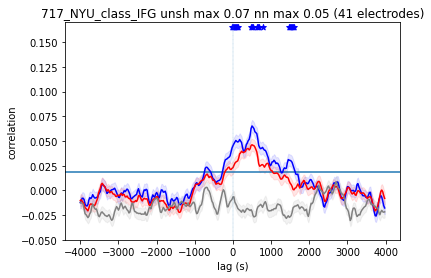

742_NYU_class_IFG
print yheight here
0.165

print minP here
0.02802090866470929

print lags here
320
[-4000 -3975 -3950 -3925 -3900 -3875 -3850 -3825 -3800 -3775 -3750 -3725
 -3700 -3675 -3650 -3625 -3600 -3575 -3550 -3525 -3500 -3475 -3450 -3425
 -3400 -3375 -3350 -3325 -3300 -3275 -3250 -3225 -3200 -3175 -3150 -3125
 -3100 -3075 -3050 -3025 -3000 -2975 -2950 -2925 -2900 -2875 -2850 -2825
 -2800 -2775 -2750 -2725 -2700 -2675 -2650 -2625 -2600 -2575 -2550 -2525
 -2500 -2475 -2450 -2425 -2400 -2375 -2350 -2325 -2300 -2275 -2250 -2225
 -2200 -2175 -2150 -2125 -2100 -2075 -2050 -2025 -2000 -1975 -1950 -1925
 -1900 -1875 -1850 -1825 -1800 -1775 -1750 -1725 -1700 -1675 -1650 -1625
 -1600 -1575 -1550 -1525 -1500 -1475 -1450 -1425 -1400 -1375 -1350 -1325
 -1300 -1275 -1250 -1225 -1200 -1175 -1150 -1125 -1100 -1075 -1050 -1025
 -1000  -975  -950  -925  -900  -875  -850  -825  -800  -775  -750  -725
  -700  -675  -650  -625  -600  -575  -550  -525  -500  -475  -450  -425
  -400  -375  -350  -32

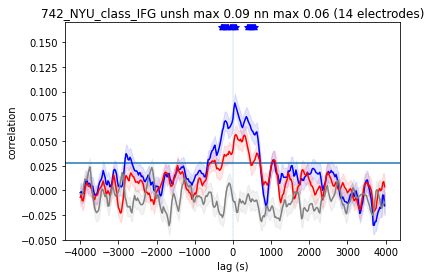

798_NYU_class_IFG
print yheight here
0.165

print minP here
0.01893237097905836

print lags here
320
[-4000 -3975 -3950 -3925 -3900 -3875 -3850 -3825 -3800 -3775 -3750 -3725
 -3700 -3675 -3650 -3625 -3600 -3575 -3550 -3525 -3500 -3475 -3450 -3425
 -3400 -3375 -3350 -3325 -3300 -3275 -3250 -3225 -3200 -3175 -3150 -3125
 -3100 -3075 -3050 -3025 -3000 -2975 -2950 -2925 -2900 -2875 -2850 -2825
 -2800 -2775 -2750 -2725 -2700 -2675 -2650 -2625 -2600 -2575 -2550 -2525
 -2500 -2475 -2450 -2425 -2400 -2375 -2350 -2325 -2300 -2275 -2250 -2225
 -2200 -2175 -2150 -2125 -2100 -2075 -2050 -2025 -2000 -1975 -1950 -1925
 -1900 -1875 -1850 -1825 -1800 -1775 -1750 -1725 -1700 -1675 -1650 -1625
 -1600 -1575 -1550 -1525 -1500 -1475 -1450 -1425 -1400 -1375 -1350 -1325
 -1300 -1275 -1250 -1225 -1200 -1175 -1150 -1125 -1100 -1075 -1050 -1025
 -1000  -975  -950  -925  -900  -875  -850  -825  -800  -775  -750  -725
  -700  -675  -650  -625  -600  -575  -550  -525  -500  -475  -450  -425
  -400  -375  -350  -32

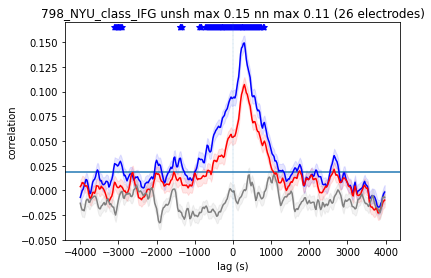

all3_NYU_class_IFG
print yheight here
0.165

print minP here
0.0130811661142316

print lags here
320
[-4000 -3975 -3950 -3925 -3900 -3875 -3850 -3825 -3800 -3775 -3750 -3725
 -3700 -3675 -3650 -3625 -3600 -3575 -3550 -3525 -3500 -3475 -3450 -3425
 -3400 -3375 -3350 -3325 -3300 -3275 -3250 -3225 -3200 -3175 -3150 -3125
 -3100 -3075 -3050 -3025 -3000 -2975 -2950 -2925 -2900 -2875 -2850 -2825
 -2800 -2775 -2750 -2725 -2700 -2675 -2650 -2625 -2600 -2575 -2550 -2525
 -2500 -2475 -2450 -2425 -2400 -2375 -2350 -2325 -2300 -2275 -2250 -2225
 -2200 -2175 -2150 -2125 -2100 -2075 -2050 -2025 -2000 -1975 -1950 -1925
 -1900 -1875 -1850 -1825 -1800 -1775 -1750 -1725 -1700 -1675 -1650 -1625
 -1600 -1575 -1550 -1525 -1500 -1475 -1450 -1425 -1400 -1375 -1350 -1325
 -1300 -1275 -1250 -1225 -1200 -1175 -1150 -1125 -1100 -1075 -1050 -1025
 -1000  -975  -950  -925  -900  -875  -850  -825  -800  -775  -750  -725
  -700  -675  -650  -625  -600  -575  -550  -525  -500  -475  -450  -425
  -400  -375  -350  -32

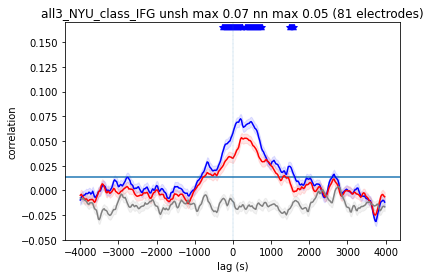

all3_NYU_class_precentral
print yheight here
0.165

print minP here
0

print lags here
320
[-4000 -3975 -3950 -3925 -3900 -3875 -3850 -3825 -3800 -3775 -3750 -3725
 -3700 -3675 -3650 -3625 -3600 -3575 -3550 -3525 -3500 -3475 -3450 -3425
 -3400 -3375 -3350 -3325 -3300 -3275 -3250 -3225 -3200 -3175 -3150 -3125
 -3100 -3075 -3050 -3025 -3000 -2975 -2950 -2925 -2900 -2875 -2850 -2825
 -2800 -2775 -2750 -2725 -2700 -2675 -2650 -2625 -2600 -2575 -2550 -2525
 -2500 -2475 -2450 -2425 -2400 -2375 -2350 -2325 -2300 -2275 -2250 -2225
 -2200 -2175 -2150 -2125 -2100 -2075 -2050 -2025 -2000 -1975 -1950 -1925
 -1900 -1875 -1850 -1825 -1800 -1775 -1750 -1725 -1700 -1675 -1650 -1625
 -1600 -1575 -1550 -1525 -1500 -1475 -1450 -1425 -1400 -1375 -1350 -1325
 -1300 -1275 -1250 -1225 -1200 -1175 -1150 -1125 -1100 -1075 -1050 -1025
 -1000  -975  -950  -925  -900  -875  -850  -825  -800  -775  -750  -725
  -700  -675  -650  -625  -600  -575  -550  -525  -500  -475  -450  -425
  -400  -375  -350  -325  -300  -

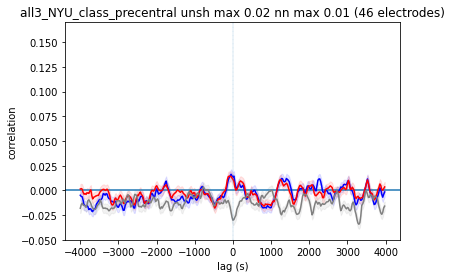

In [ ]:
run_experiments_sig(experiment_list)